In [1]:
import pandas as pd
import pickle 

from carat.utils import get_example_data
from carat.core import compute_psi, LPFormulator
from carat.processing import DataPreprocessor, PreProcessConfig
from carat.vis import mermaid_plot, SankeyDiagramGenerator

c:\Users\Emma\anaconda3\envs\carat\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load value chain graph
graph = pickle.load(open("data/newest_graph_2.pkl", "rb"))

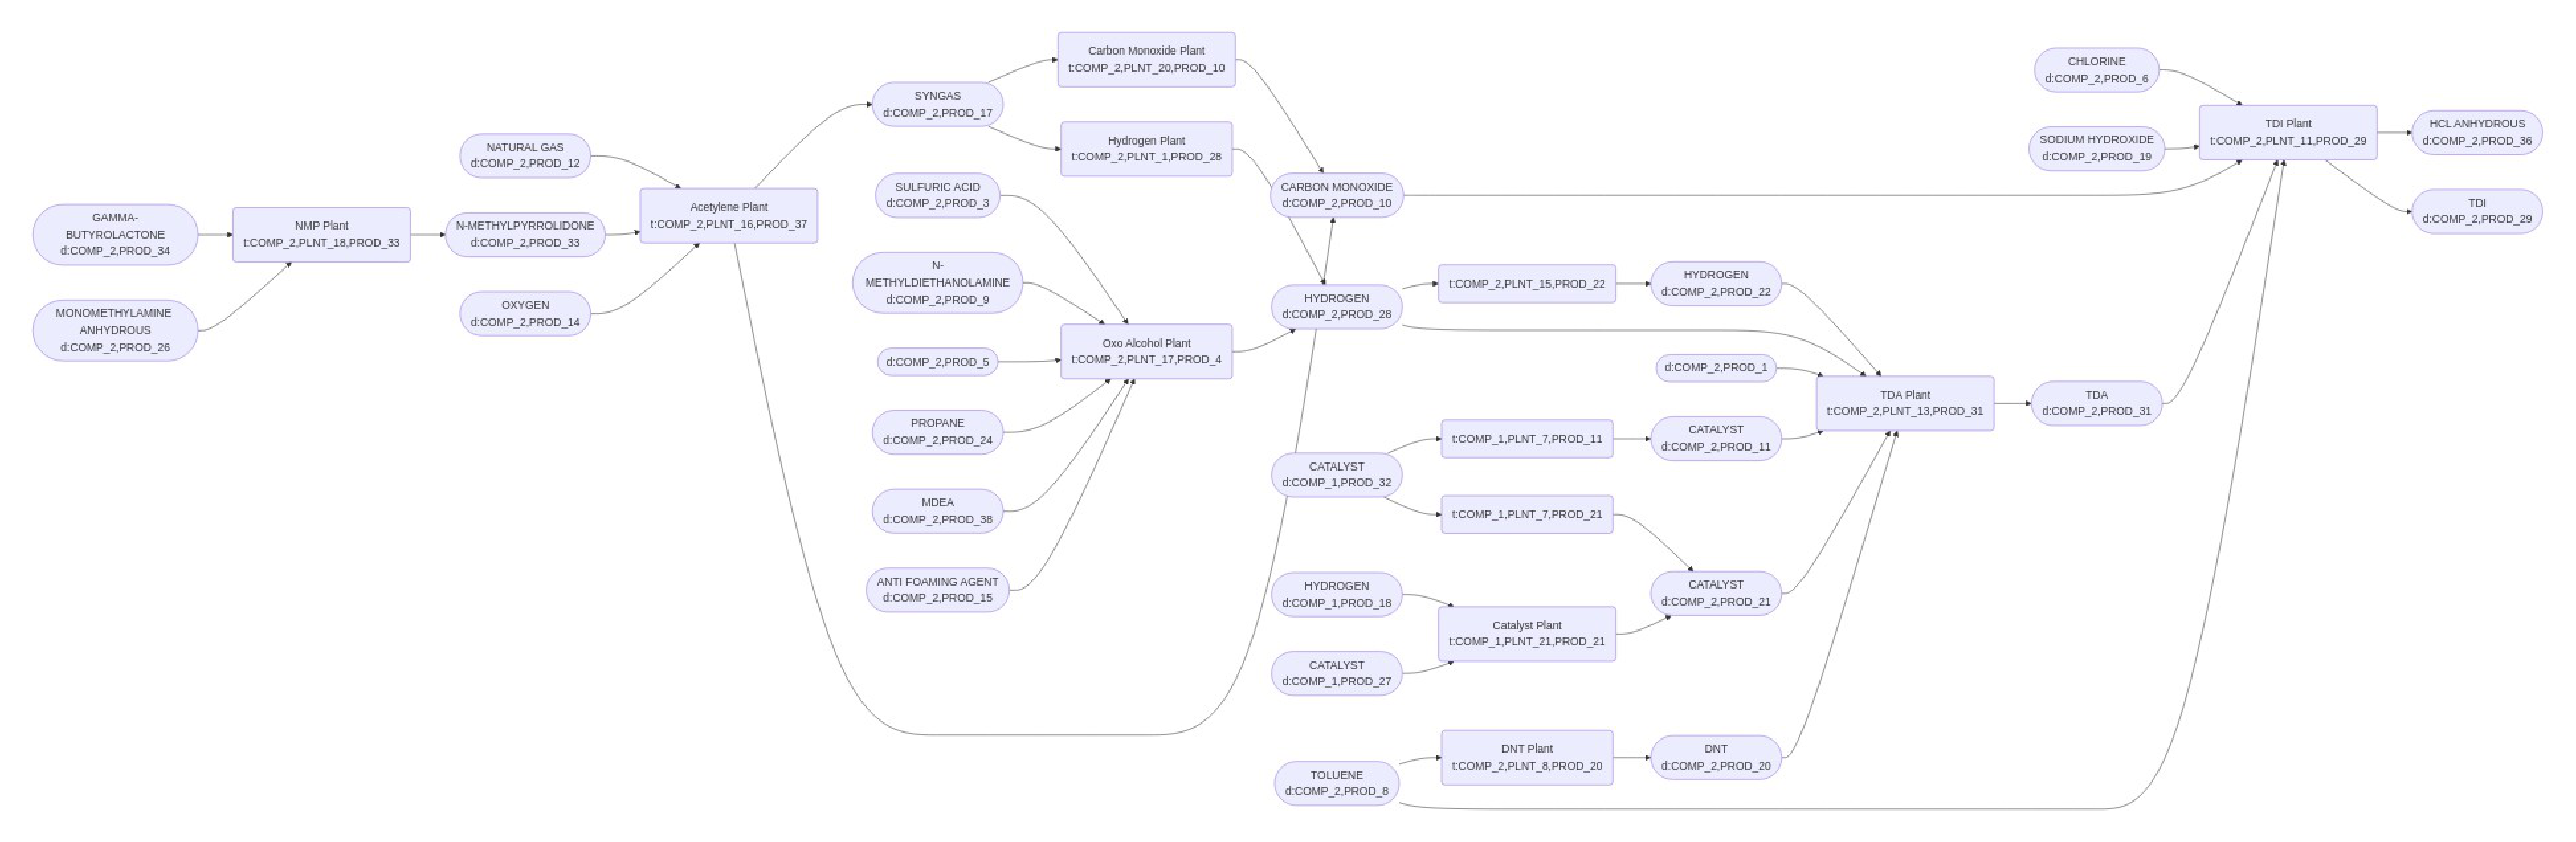

In [3]:
# Visualise value chain graph
mermaid_plot(graph)

In [4]:
# Load value chain dataset for example
data = get_example_data("data/tdi_anon_dict_new.pkl")

# Visualise the bill of materials
data['trip_bom'].tail()

PBG_TXT MOV_CAT  \
COCD   BP      PBG_GR  PBG     SMILES                                        
COMP_2 PLNT_16 PROD_37 PROD_17 [HH]          1:1 SYNGAS 1:1 SYNGAS      BY   
                       PROD_37 C#C         ACETYLENE JOINT VENTURE      GR   
                               C#CC        ACETYLENE JOINT VENTURE      GR   
                               C=C=C       ACETYLENE JOINT VENTURE      GR   
                       PROD_30 CN1CCCC1=O     NMP-POLYMER SOLUTION      BY   

                                           RATIO BP_TXT  
COCD   BP      PBG_GR  PBG     SMILES                    
COMP_2 PLNT_16 PROD_37 PROD_17 [HH]         4.53    NaN  
                       PROD_37 C#C          1.41    NaN  
                               C#CC         0.02    NaN  
                               C=C=C        0.01    NaN  
                       PROD_30 CN1CCCC1=O   0.01    NaN

In [5]:
# Atom mapping with RXNMapper - use the consistent variable name
psi = compute_psi(data['trip_bom'])

# Convert the nested dictionary `psi` to a DataFrame
psi_df = pd.DataFrame.from_dict(psi, orient='columns')

# Visualise an example boa for a triplet
psi_df['t:COMP_2|PLNT_11|PROD_29'].dropna()


PROD_31  Cc1ccc(N)cc1N  PROD_29  Cc1ccc(N=C=O)cc1N=C=O  C    0.777778
PROD_17  [C-]#[O+]      PROD_29  Cc1ccc(N=C=O)cc1N=C=O  C    0.222222
                        PROD_36  O=C=O                  C    1.000000
                        PROD_17  [C-]#[O+]              C    1.000000
Name: t:COMP_2|PLNT_11|PROD_29, dtype: float64

In [6]:
# Prepcrocess the data for LP formulation
config = PreProcessConfig(graph=graph, **data)

preprocessed_data = DataPreprocessor(config).preprocess()

In [7]:
# Formulate and solve LP model
lp_solver = LPFormulator(preprocessed_data, inlets="C1")
results = lp_solver.solve(output_results=True, pkl_output_path="")


INFO:carat.core.lp_opt:Beta_d:
      COCD      PBG                               SMILES ELEMENT ATTRIBUTE  \
0   COMP_2  PROD_12                                    C       C  biogenic   
1   COMP_2  PROD_12                                    C       C    fossil   
2   COMP_2  PROD_38                             C1CNCCN1       C  biogenic   
3   COMP_2  PROD_38                             C1CNCCN1       C    fossil   
4   COMP_2  PROD_26                                   CN       C  biogenic   
5   COMP_2  PROD_26                                   CN       C    fossil   
6   COMP_2  PROD_36                                O=C=O       C  biogenic   
7   COMP_2  PROD_36                                O=C=O       C    fossil   
8   COMP_2  PROD_17                            [C-]#[O+]       C  biogenic   
9   COMP_2  PROD_17                            [C-]#[O+]       C    fossil   
10  COMP_2  PROD_31                        Cc1ccc(N)cc1N       C  biogenic   
11  COMP_2  PROD_31              

In [8]:
# Sankey Visualisation

# Extract LP results for the Sankey diagram
beta_t_res = results["beta_t_res"]
beta_d_res = results["beta_d_res"]

graph = pickle.load(open("data/newest_graph_2.pkl", "rb"))

# Initialize the generator
generator = SankeyDiagramGenerator(graph, beta_d_res, beta_t_res)

# Prepare the data
generator.prepare_data()

# Generate the diagram
fig = generator.generate_sankey_diagram(
    title="Custom Biogenic Carbon Content Visualization", width=1200, height=800
)

# Display the diagram
generator.display_diagram(fig)

# Save the diagram
generator.save_diagram(fig, "sankey_diagram.html", scale=3)


Diagram saved as sankey_diagram.html
